# Финальный проект // ПРОМЫШЛЕННОСТЬ

Загрузим данные и библиотеки

In [1]:
import pandas as pd

In [2]:
data_arc = pd.read_csv('/datasets/final_steel/data_arc.csv')
data_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')
data_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')
data_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
data_temp = pd.read_csv('/datasets/final_steel/data_temp.csv')
data_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
data_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')

Теперь поочередно откроем каждый файл и проведем исследовательский анализ данных. В конце опишем результаты.

## Данные об электродах

In [3]:
display(data_arc)
display(data_arc.dtypes)
display(data_arc.corr())
print('Количество дубликатов: ', data_arc.duplicated().sum())

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397
...,...,...,...,...,...
14871,3241,2019-09-01 03:58:58,2019-09-01 04:01:35,0.533670,0.354439
14872,3241,2019-09-01 04:05:04,2019-09-01 04:08:04,0.676604,0.523631
14873,3241,2019-09-01 04:16:41,2019-09-01 04:19:45,0.733899,0.475654
14874,3241,2019-09-01 04:31:51,2019-09-01 04:32:48,0.220694,0.145768


key                       int64
Начало нагрева дугой     object
Конец нагрева дугой      object
Активная мощность       float64
Реактивная мощность     float64
dtype: object

,key,Активная мощность,Реактивная мощность
key,1.000000,-0.021382,-0.004396
Активная мощность,-0.021382,1.000000,0.054437
Реактивная мощность,-0.004396,0.054437,1.000000


Количество дубликатов:  0


У нас 3241 партия.

Типы данных в таблице совпадают, дубликатов нет, корреляция отсутствует.

Напишем функцию очистки от выбросов.

In [4]:
def cleaning(data, parametr):
    Q1 = data[parametr].quantile(0.25)
    Q3 = data[parametr].quantile(0.75)
    IQR = Q3 - Q1
    data_new = data.loc[(data[parametr] < Q3+1.5*IQR) & 
                                (data[parametr] > Q1-1.5*IQR)]
    return data_new

Применим ее к столбцам мощностей

In [5]:
data_arc = cleaning(data_arc, 'Активная мощность')
data_arc = cleaning(data_arc, 'Реактивная мощность')

Есть мысли о замене двух мощностей на полную, вычленив ее из уравнения:

$$
Реактивная \ мощность = √(Полная \ мощность^{2} – Активная \ мощность^{2})
$$

Откуда следует:

$$
Полная \ мощность = √(Реактивная \ мощность^{2} + Активная \ мощность^{2})
$$

Однако, перед этим просуммируем значения мощностей по партиям. 

Также есть предложение, найти суммарное время нагрева в партии, и в дальнейшем представить как признак.

Итак, порядок действий таков:
 1. Найдем время нагрева одной итерации;
 2. Просуммируем время (представив итоговое значение в секундах) и мощности по партии;
 3. Заменим имеющиеся мощности на полную, используя формулы выше;
 4. Удалим ненужные столбцы.

In [6]:
# 1
data_arc['Конец нагрева дугой'] = pd.to_datetime(data_arc['Конец нагрева дугой'], format = '%Y-%m-%dT%H:%M:%S')
data_arc['Начало нагрева дугой'] = pd.to_datetime(data_arc['Начало нагрева дугой'], format = '%Y-%m-%dT%H:%M:%S')
delta = data_arc['Конец нагрева дугой'] - data_arc['Начало нагрева дугой']
data_arc['Время нагрева'] = (pd.DatetimeIndex(delta).hour * 3600 +
             pd.DatetimeIndex(delta).minute * 60 + 
             pd.DatetimeIndex(delta).second)

# 2
data_arc_group = data_arc.groupby('key')['Активная мощность', 'Реактивная мощность', 'Время нагрева'].sum()

# 3 
data_arc_group['Полная мощность'] = (data_arc_group['Активная мощность']**2 + data_arc_group['Реактивная мощность']**2)**0.5

# 4
data_arc_new = data_arc_group.drop(['Активная мощность', 'Реактивная мощность'], axis = 1)
data_arc_new

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Passing timedelta64-dtype data is deprecated, will raise a TypeError in a future version
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Passing timedelta64-dtype data is deprecated, will raise a TypeError in a future version
  import sys


,Время нагрева,Полная мощность
key,,
1,733,3.854529
2,811,3.648398
3,655,2.989502
4,741,3.813674
5,454,2.104539
...,...,...
3237,909,4.844014
3238,546,2.695151
3239,1216,5.608989


Из 4ех столбцов сделали два - коротко и понятно. 

Теперь построим график корреляции.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f72a2055610>,
      dtype=object)

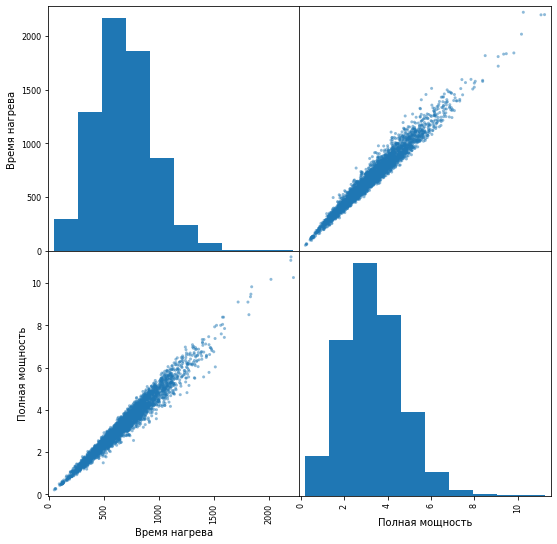

In [7]:
pd.plotting.scatter_matrix(data_arc_new, figsize = (9, 9))

Да, в действительности получили корреляцию, хотя до удаления выбросов известно нам об этом не было. Узнаем насколько сильно признаки скоррелированы.

In [8]:
data_arc_new.corr()

,Время нагрева,Полная мощность
Время нагрева,1.000000,0.979182
Полная мощность,0.979182,1.000000


Почти единица между временем нагрева и мощностью.<br>
Поэтому избавимся от одного из признаков (сделали это в конце исследовательской части проекта: убрали время нагрева)

Также откинем временные выбросы, если они есть. 

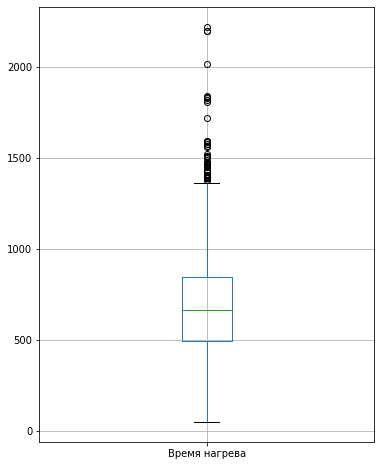

In [9]:
data_arc_new.boxplot('Время нагрева', figsize = (6,8))

Уберем их 

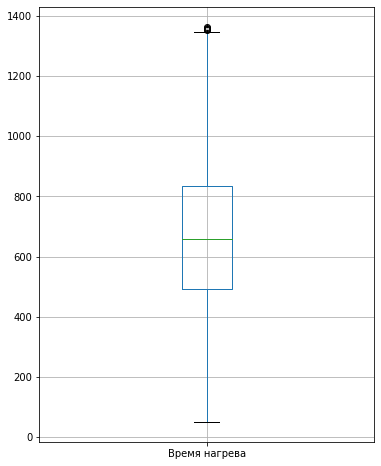

In [10]:
data_arc_new = cleaning(data_arc_new, 'Время нагрева')

data_arc_new.boxplot('Время нагрева', figsize = (6,8))

Здорово, с этими данными закончили. Переходим к сыпучим материалам.

## Данные о подаче сыпучих материалов (объём)

In [11]:
display(data_bulk)
display(data_bulk.dtypes)
print('Количество дубликатов: ', data_bulk.duplicated().sum())

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,NaN,NaN,170.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,252.0,NaN,130.0,206.0
3125,3238,NaN,NaN,126.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,254.0,NaN,108.0,106.0
3126,3239,NaN,NaN,NaN,NaN,NaN,114.0,NaN,NaN,NaN,NaN,NaN,158.0,NaN,270.0,88.0
3127,3240,NaN,NaN,NaN,NaN,NaN,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.0,54.0


key          int64
Bulk 1     float64
Bulk 2     float64
Bulk 3     float64
Bulk 4     float64
Bulk 5     float64
Bulk 6     float64
Bulk 7     float64
Bulk 8     float64
Bulk 9     float64
Bulk 10    float64
Bulk 11    float64
Bulk 12    float64
Bulk 13    float64
Bulk 14    float64
Bulk 15    float64
dtype: object

Количество дубликатов:  0


Типы данных совпадают.<br>
Посмотрим на количество пропусков значений

In [12]:
data_bulk.isna().sum()

key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64

Их великое множество, что вероятней всего означает отсутствие добавки сыпучик материалов. Поэтому все Nan-ы заменим на 0. 

Однако не будем торопиться удалять столбцы, в которых количество нулевых значений приближается к 100%, возможно, это сыграет определенную роль в конечном результате. 

Так как нам необходимо предсказать итоговую температуру, есть идея просуммировать все сыпучие материалы, добавленные на протяжении всего процесса легирования. Также поступить и с проволочными материалами.
В таблице оставить столбец суммы и номер партии.

In [13]:
data_bulk = data_bulk.fillna(0)

bulk = ['Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6', 'Bulk 7', 'Bulk 8', 
        'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 12', 'Bulk 13', 'Bulk 14', 'Bulk 15']
data_bulk['Bulk_sum'] = 0 
for i in bulk:
    data_bulk['Bulk_sum'] += data_bulk[i]

data_bulk = data_bulk.drop(bulk, axis = 1)
data_bulk

,key,Bulk_sum
0,1,553.0
1,2,582.0
2,3,544.0
3,4,595.0
4,5,584.0
...,...,...
3124,3237,758.0
3125,3238,594.0
3126,3239,630.0
3127,3240,272.0


Почистим от выбросов

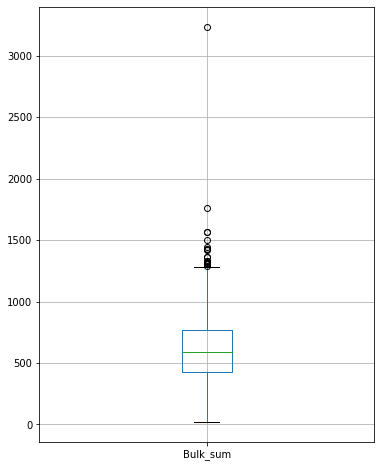

In [14]:
data_bulk.boxplot('Bulk_sum', figsize = (6,8))

In [15]:
data_bulk = cleaning(data_bulk, 'Bulk_sum')
print('Количество строк:', len(data_bulk))

Количество строк: 3108


Минус 21 строка ~ минус выбросы:)

## Данные о подаче сыпучих материалов (время)

In [16]:
display(data_bulk_time)
display(data_bulk_time.dtypes)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,NaN,NaN,2019-08-31 22:51:28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-31 22:46:52,NaN,2019-08-31 22:46:52,2019-08-31 22:46:52
3125,3238,NaN,NaN,2019-08-31 23:39:11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-31 23:33:09,NaN,2019-08-31 23:33:09,2019-08-31 23:33:09
3126,3239,NaN,NaN,NaN,NaN,NaN,2019-09-01 01:51:58,NaN,NaN,NaN,NaN,NaN,2019-09-01 01:39:41,NaN,2019-09-01 01:33:25,2019-09-01 01:33:25
3127,3240,NaN,NaN,NaN,NaN,NaN,2019-09-01 03:12:40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-01 02:41:27,2019-09-01 02:41:27


key         int64
Bulk 1     object
Bulk 2     object
Bulk 3     object
Bulk 4     object
Bulk 5     object
Bulk 6     object
Bulk 7     object
Bulk 8     object
Bulk 9     object
Bulk 10    object
Bulk 11    object
Bulk 12    object
Bulk 13    object
Bulk 14    object
Bulk 15    object
dtype: object

Пока не появились мысли, как в обучении помогут такие данные, как время и дата, и как их можно использовать разумно. Поэтому оставим пока, как есть. В случае чего определим в тип данных - datetime.

## Данные о продувке сплава газом

In [17]:
display(data_gas)
display(data_gas.dtypes)
print('Количество дубликатов: ', data_gas.duplicated().sum())

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
...,...,...
3234,3237,5.543905
3235,3238,6.745669
3236,3239,16.023518
3237,3240,11.863103


key        int64
Газ 1    float64
dtype: object

Количество дубликатов:  0


Типы данных корректны. Дубликатов нет. Выбросы ? 

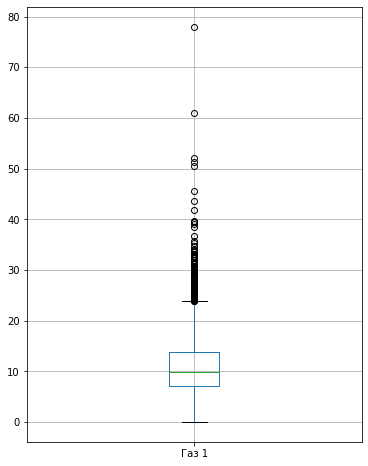

In [18]:
data_gas.boxplot('Газ 1', figsize = (6,8))

In [19]:
data_gas = cleaning(data_gas, 'Газ 1')
print('Количество строк:', len(data_gas))

Количество строк: 3113


## Результаты измерения температуры

In [20]:
display(data_temp)
display(data_temp.dtypes)

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
...,...,...,...
15902,3241,2019-09-01 04:03:30,1586.0
15903,3241,2019-09-01 04:16:12,NaN
15904,3241,2019-09-01 04:22:39,NaN
15905,3241,2019-09-01 04:33:42,NaN


key               int64
Время замера     object
Температура     float64
dtype: object

Есть замечание, что у некоторых партий нет последнего замера температуры. А так как это является для нас целевым признаком, обучить на таких данных модель мы не сможем.

В связи с этим:
 1. Удалим все партии, где отсутствуют показания последнего замера температуры;
 2. А также те партии, где присутствует всего один замер (в противном случае произойдет утечка целевого признака).

In [21]:
# 1
data_temp['temp_new_1'] = data_temp.key.replace(data_temp.groupby('key').Температура.nth(-1))
data_temp = data_temp.dropna()
data_temp = data_temp.drop(['temp_new_1'], axis = 1)
data_temp

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
...,...,...,...
12262,2498,2019-08-06 02:19:26,1593.0
12263,2498,2019-08-06 02:25:31,1594.0
12264,2499,2019-08-06 02:40:25,1569.0
12265,2499,2019-08-06 02:54:24,1604.0


Для решения второго пункта узнаем, есть ли единичные замеры температуры в партиях.

In [22]:
data_temp_1zamer = data_temp.groupby('key').filter(lambda x: x['Температура'].count() == 1)
data_temp_1zamer

,key,Время замера,Температура
1100,195,2019-05-10 14:10:23,1583.0
1554,279,2019-05-13 23:07:28,1603.0


Ответ: да, имеется 2 такие партии.<br>
Удалим их.

In [23]:
# 2
data_temp = data_temp.groupby('key').filter(lambda x: x['Температура'].count() != 1)

Теперь возьмем от каждой партии последнее значение температуры (это будет нашим целевым признаком).

In [24]:
data_temp = data_temp.groupby('key')['Температура'].agg(['last'])
data_temp

,last
key,
1,1613.0
2,1602.0
3,1599.0
4,1625.0
5,1602.0
...,...
2495,1591.0
2496,1591.0
2497,1589.0


Что с аномалиями ? 

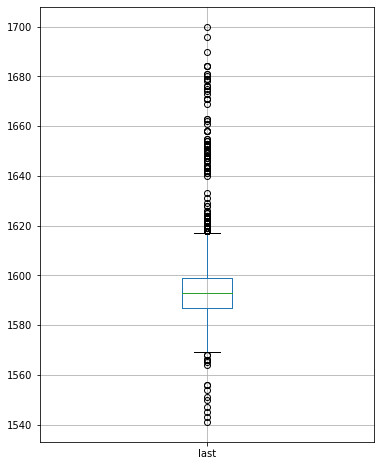

In [25]:
data_temp.boxplot('last', figsize = (6,8))

Почистим

In [26]:
data_temp = cleaning(data_temp, 'last')
print('Количество строк:', len(data_temp))

Количество строк: 2257


Здесь закончили, переходим к проволочными материалам

## Данные о проволочных материалах (объём)

In [27]:
display(data_wire)
display(data_wire.dtypes)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
3076,3237,38.088959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,56.128799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,143.357761,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,34.070400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


key         int64
Wire 1    float64
Wire 2    float64
Wire 3    float64
Wire 4    float64
Wire 5    float64
Wire 6    float64
Wire 7    float64
Wire 8    float64
Wire 9    float64
dtype: object

Ситуация аналогичная данным о подачи сыпучих материалов.

Узнаем количество пропусков.

In [28]:
data_wire.isna().sum()

key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64

Просуммируем и оставим в таблице только общий объем по партии.

In [29]:
data_wire = data_wire.fillna(0)

wire = ['Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 5', 'Wire 6', 'Wire 7', 'Wire 8', 'Wire 9']
data_wire['Wire_sum'] = 0 
for i in wire:
    data_wire['Wire_sum'] += data_wire[i]

data_wire = data_wire.drop(wire, axis = 1)
data_wire

,key,Wire_sum
0,1,60.059998
1,2,96.052315
2,3,91.160157
3,4,89.063515
4,5,98.352796
...,...,...
3076,3237,38.088959
3077,3238,56.128799
3078,3239,143.357761
3079,3240,34.070400


Уберем выбросы

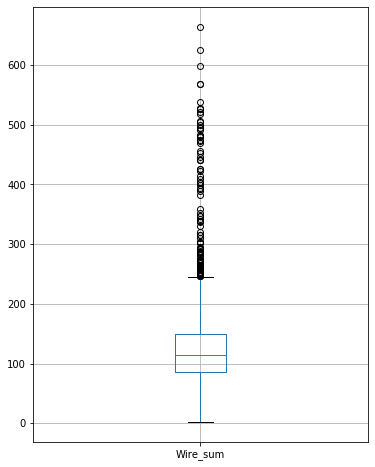

In [30]:
display(data_wire.boxplot('Wire_sum', figsize = (6,8)))

In [31]:
data_wire = cleaning(data_wire, 'Wire_sum')
print('Количество строк:', len(data_wire))

Количество строк: 2974


## Данные о проволочных материалах (время).

In [32]:
display(data_wire_time)
display(data_wire_time.dtypes)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
3076,3237,2019-08-31 22:50:20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,2019-08-31 23:38:24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,2019-09-01 01:50:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,2019-09-01 03:12:02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


key        int64
Wire 1    object
Wire 2    object
Wire 3    object
Wire 4    object
Wire 5    object
Wire 6    object
Wire 7    object
Wire 8    object
Wire 9    object
dtype: object

Пока непонятно, как присовокупить эти данные. Оставляем, как есть.

## Объединим все необходимые таблицы

Итого, по вышеизложенным идеям и скорректированным датафреймам, объединим следующие таблицы: 
 * Данные об электродам;
 * Данные о подаче сыпучих материалов (объём);
 * Данные о продувке сплава газом;
 * Результаты измерения температуры;
 * Данные о проволочных материалах (объём).
 
Мерджить будем по таблице температур, так как они являются целевым фактором.

In [33]:
data_t_a = data_temp.merge(data_arc_new, on = 'key', how = 'left')
data_t_a_b = data_t_a.merge(data_bulk, on = 'key', how = 'left')
data_t_a_b_g = data_t_a_b.merge(data_gas, on = 'key', how = 'left')
data_final = data_t_a_b_g.merge(data_wire, on = 'key', how = 'left')
data_final

,key,last,Время нагрева,Полная мощность,Bulk_sum,Газ 1,Wire_sum
0,1,1613.0,733.0,3.854529,553.0,NaN,60.059998
1,2,1602.0,811.0,3.648398,582.0,12.555561,96.052315
2,3,1599.0,655.0,2.989502,544.0,NaN,91.160157
3,5,1602.0,454.0,2.104539,584.0,5.413692,98.352796
4,6,1596.0,554.0,2.721945,676.0,11.273392,108.224477
...,...,...,...,...,...,...,...
2252,2495,1591.0,723.0,3.985197,719.0,7.125735,89.150879
2253,2496,1591.0,940.0,5.055976,796.0,9.412616,114.179527
2254,2497,1589.0,569.0,2.884756,665.0,6.271699,103.134723
2255,2498,1594.0,750.0,4.143362,733.0,14.953657,118.110717


Узнаем, есть ли пропуски в данных

In [34]:
print('Количество строк: ', len(data_final))
data_final.isna().sum()

Количество строк:  2257


key                  0
last                 0
Время нагрева       28
Полная мощность     28
Bulk_sum            67
Газ 1               95
Wire_sum           103
dtype: int64

Так как пропущенные значения рационально заполнить не получится, не нарушив тождественность данных, удалим строки с пропусками. 

In [35]:
data_final = data_final.dropna()
print('Количество строк: ', len(data_final))

Количество строк:  2002


In [36]:
data_final.isna().sum()

key                0
last               0
Время нагрева      0
Полная мощность    0
Bulk_sum           0
Газ 1              0
Wire_sum           0
dtype: int64

В конечном итоге получился датасет на 2020 строк.

Проверим еще наши признаки на мультиколлинеарность.

,key,last,Время нагрева,Полная мощность,Bulk_sum,Газ 1,Wire_sum
key,1.000000,-0.071441,-0.052747,-0.034750,-0.015625,-0.049862,0.001180
last,-0.071441,1.000000,0.139784,0.139526,0.144090,-0.000003,0.115542
Время нагрева,-0.052747,0.139784,1.000000,0.973770,0.328788,0.272318,0.088415
Полная мощность,-0.034750,0.139526,0.973770,1.000000,0.367823,0.253658,0.077865
Bulk_sum,-0.015625,0.144090,0.328788,0.367823,1.000000,0.258181,0.049045
Газ 1,-0.049862,-0.000003,0.272318,0.253658,0.258181,1.000000,0.157941
Wire_sum,0.001180,0.115542,0.088415,0.077865,0.049045,0.157941,1.000000


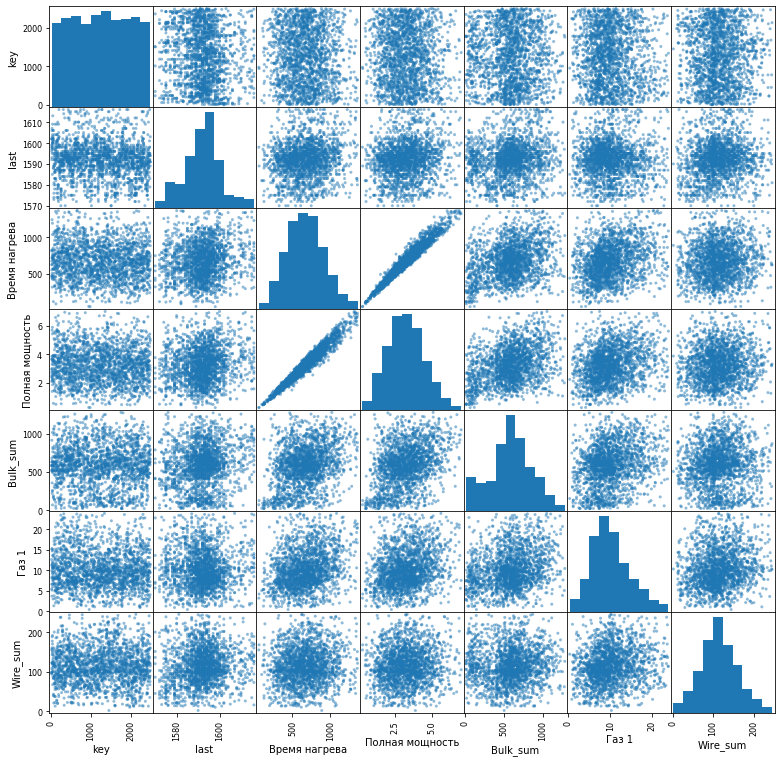

In [37]:
pd.plotting.scatter_matrix(data_final, figsize = (13, 13))
data_final.corr()

Заметим, что данные полной мощности и времени нагрева дуги сильно коллинеарны (замечание было описано в начале работы). Поэтому отбросим один из факторов, например, время нагрева.

In [38]:
data_final = data_final.drop(['Время нагрева'], axis = 1)
data_final

,key,last,Полная мощность,Bulk_sum,Газ 1,Wire_sum
1,2,1602.0,3.648398,582.0,12.555561,96.052315
3,5,1602.0,2.104539,584.0,5.413692,98.352796
4,6,1596.0,2.721945,676.0,11.273392,108.224477
5,7,1599.0,2.987769,627.0,9.836267,98.061600
6,8,1598.0,2.425716,914.0,15.171553,155.282394
...,...,...,...,...,...,...
2252,2495,1591.0,3.985197,719.0,7.125735,89.150879
2253,2496,1591.0,5.055976,796.0,9.412616,114.179527
2254,2497,1589.0,2.884756,665.0,6.271699,103.134723
2255,2498,1594.0,4.143362,733.0,14.953657,118.110717


Также изменим индексы, удалив старые, и сформируем правильную числовую последовательность.<br>
В том числе, удалим параметр "key". Он нам больше не нужен. Иначе будет создавать лишние шумы при обучении моделей.

In [39]:
data_final = data_final.drop(['key'], axis = 1).reset_index(drop = True)
data_final

,last,Полная мощность,Bulk_sum,Газ 1,Wire_sum
0,1602.0,3.648398,582.0,12.555561,96.052315
1,1602.0,2.104539,584.0,5.413692,98.352796
2,1596.0,2.721945,676.0,11.273392,108.224477
3,1599.0,2.987769,627.0,9.836267,98.061600
4,1598.0,2.425716,914.0,15.171553,155.282394
...,...,...,...,...,...
1997,1591.0,3.985197,719.0,7.125735,89.150879
1998,1591.0,5.055976,796.0,9.412616,114.179527
1999,1589.0,2.884756,665.0,6.271699,103.134723
2000,1594.0,4.143362,733.0,14.953657,118.110717


Получили датасет, почти готовый для обучения моделей.

Необходимо также выполнить предобработку для обучения. Среди этого:
 1. Разделить данные на обучающую, валидационную и тестовую выборки + выделить целевой признак;
 2. Применить метод стандартизации данных (например, масштабирование признаков) на обучающей выборке и преобразовать остальные.

Далее последуют такие операции:
 1. Провести обучение моделей (дерево решений, случайный лес, линейную регрессию) через поиск наиболее подходящих гиперпараметров при помощи цикла / GridSearchCV / кросс-валидации;
 2. Выбрать лучшие и протестировать;
 3. Добиться нужного MAE;
 4. Провести анализ важности факторов и составить отчет.

**Из вопросов:**
 * Правильно ли, что я отрезал выбросы по всем признакам без задней мысли / можно ли так делать или надо аргументирвоать почему есть такая возможность ?
 * Следует ли в признаки записать еще и среднюю температуру по партии / может ли это повлиять на конечный результат (в положительном смысле) ? - скорее всего, без проведенного опыта трудно ответить на этот вопрос

# Моделирование

Загрузим все необходимые для этого библиотеки

In [40]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_absolute_error, make_scorer
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import numpy as np

Теперь разделим данные на 3 выборки: обучающую, валидационную и тестовую.

Делить будем исходя из следующего соотношения: 60% / 20% / 20%.

In [41]:
train, valid = train_test_split(data_final, test_size = 0.4, random_state = 12345)
valid, test = train_test_split(valid, test_size = 0.5, random_state = 12345)

features_train = train.drop(['last'], axis = 1)
target_train = train['last']
features_valid = valid.drop(['last'], axis = 1)
target_valid = valid['last']
features_test = test.drop(['last'], axis = 1)
target_test = test['last']

Проверим, правильно ли мы разбили выборки

In [42]:
print(features_train.shape)
print(features_valid.shape)
print(features_test.shape)

features_train

(1201, 4)
(400, 4)
(401, 4)


,Полная мощность,Bulk_sum,Газ 1,Wire_sum
768,2.180192,582.0,8.652169,71.136002
1003,3.249797,465.0,8.672860,105.066002
1047,2.482262,482.0,11.654313,205.390652
1160,3.299945,494.0,10.399073,106.095596
40,2.069600,631.0,7.897148,120.076320
...,...,...,...,...
1444,3.090647,584.0,7.788652,109.980003
129,4.449577,667.0,12.595186,116.276169
1309,2.331922,446.0,8.878055,136.328398
1509,3.235519,609.0,7.852912,170.181427


Верно. Теперь промасштабируем наши признаки.

In [43]:
#kol = ['Полная мощность', 'Bulk_sum', 'Газ 1', 'Wire_sum']
#[kol]
sclaler = StandardScaler()
sclaler.fit(features_train)
features_train = sclaler.transform(features_train)
features_valid = sclaler.transform(features_valid)
features_test = sclaler.transform(features_test)

features_train

array([[-0.84527973, -0.02657281, -0.3402953 , -0.96969167],
       [ 0.02080643, -0.46410869, -0.33574199, -0.23841852],
       [-0.60068585, -0.4005351 ,  0.32037339,  1.9238191 ],
       ...,
       [-0.72242054, -0.53516153, -0.29058555,  0.43536134],
       [ 0.00924511,  0.07439701, -0.51618421,  1.16497557],
       [-0.77276573,  0.07439701, -0.68896411, -1.10283392]])

Теперь проведем обучение на нескольких моделях с разными гиперпараметрами.<br>
У нас задача регрессии, надо предсказать числовой параметр. 

Напишем свой "scorer" для определения наилучших гиперпараметров

In [44]:
def mae(target, prediction):
    mae = np.sum(abs(target - prediction)) / len(prediction)
    return mae

mae_scorer = make_scorer(mae, greater_is_better = False)

## Линейная регрессия

In [45]:
%%time

model = LinearRegression()
model.fit(features_train, target_train)

valid_prediction = model.predict(features_valid)
print("MAE валидационной выборке:", mean_absolute_error(target_valid, valid_prediction))

MAE валидационной выборке: 6.804631491169627
CPU times: user 3.45 ms, sys: 0 ns, total: 3.45 ms
Wall time: 2.92 ms


## Дерево решений

In [46]:
%%time

best_depth = 0
best_model_tree = None
best_mae = 1000
for depth in range(1, 20):
    model_tree = DecisionTreeRegressor(random_state = 12345, max_depth = depth)
    model_tree.fit(features_train, target_train)
    prediction = model_tree.predict(features_valid)
    mae = mean_absolute_error(target_valid, prediction)
    if mae < best_mae:
        best_mae = mae
        best_model_tree = model_tree
        best_depth = depth

print("MAE:", best_mae, 'Глубина:', best_depth)

MAE: 6.851960485018505 Глубина: 2
CPU times: user 94.1 ms, sys: 0 ns, total: 94.1 ms
Wall time: 93 ms


## Случайный лес

In [47]:
%%time

best_est = 0
best_depth = 0
best_model_forest = None
best_mae = 1000
for est in range(5, 40, 5):
    for depth in range(1, 14):
        model_forest = RandomForestRegressor(random_state = 12345, max_depth = depth, n_estimators = est)
        model_forest.fit(features_train, target_train)
        prediction = model_forest.predict(features_valid)
        mae = mean_absolute_error(target_valid, prediction)
        if mae < best_mae:
            best_mae = mae
            best_model_forest = model_forest
            best_est = est
            best_depth = depth

print("MAE на валидационной выборке:", best_mae, 'Глубина:', best_depth, ', Количество деревьев:', best_est)

MAE на валидационной выборке: 6.843010893827333 Глубина: 2 , Количество деревьев: 25
CPU times: user 6.01 s, sys: 20 ms, total: 6.03 s
Wall time: 6.03 s


## LGBMRegressor

Определим наилучшие гиперпараметры у LGBMRegressor

In [48]:
%%time

model_lgb = LGBMRegressor()

param = {'n_estimators': range(60, 200, 20),
        'num_leaves': range(5, 27, 2)}

grid_gbm = GridSearchCV(model_lgb, param, cv=5, scoring = mae_scorer)
grid_gbm.fit(features_train, target_train)
print(grid_gbm.best_estimator_)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=60, n_jobs=-1, num_leaves=5, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
CPU times: user 4min 46s, sys: 3.66 s, total: 4min 50s
Wall time: 4min 55s


Запустим на валидационной выборке с лучшими гиперпараметрами

In [49]:
model_lgb = LGBMRegressor(**grid_gbm.best_params_, random_state = 1234)
model_lgb.fit(features_train, target_train)
pred_valid = model_lgb.predict(features_valid)
print("MAE валидационной выборке:", mean_absolute_error(target_valid, pred_valid))

MAE валидационной выборке: 6.765675155526896


## CatBoostRegressor

In [50]:
%%time

model_cat = CatBoostRegressor(verbose = 50, 
                                  loss_function='MAE', 
                                  iterations=1000, 
                                  learning_rate=0.001,
                                  random_seed = 0)
model_cat.fit(features_train, target_train)
prediction = model_cat.predict(features_valid)
print("MAE на валидационной выборке:", mean_absolute_error(prediction, target_valid))

0:	learn: 6.6563745	total: 49.1ms	remaining: 49s
50:	learn: 6.6273375	total: 469ms	remaining: 8.72s
100:	learn: 6.5984380	total: 1.04s	remaining: 9.26s
150:	learn: 6.5708641	total: 1.62s	remaining: 9.13s
200:	learn: 6.5446762	total: 2.21s	remaining: 8.77s
250:	learn: 6.5202265	total: 2.78s	remaining: 8.31s
300:	learn: 6.4956675	total: 3.36s	remaining: 7.8s
350:	learn: 6.4726222	total: 3.85s	remaining: 7.13s
400:	learn: 6.4498946	total: 4.44s	remaining: 6.63s
450:	learn: 6.4285010	total: 5.01s	remaining: 6.1s
500:	learn: 6.4079880	total: 5.51s	remaining: 5.49s
550:	learn: 6.3882756	total: 6.08s	remaining: 4.96s
600:	learn: 6.3690003	total: 6.58s	remaining: 4.37s
650:	learn: 6.3513663	total: 7.16s	remaining: 3.84s
700:	learn: 6.3340563	total: 7.74s	remaining: 3.3s
750:	learn: 6.3184036	total: 8.22s	remaining: 2.73s
800:	learn: 6.3030571	total: 8.81s	remaining: 2.19s
850:	learn: 6.2886940	total: 9.38s	remaining: 1.64s
900:	learn: 6.2747557	total: 9.96s	remaining: 1.09s
950:	learn: 6.26128

# Тестирование 

Объединим тренировочную и валидационную выборки, обучим на них с лучшими гиперпараметрами для каждой модели и проведем тест.

In [51]:
features_train_valid = np.concatenate((features_train, features_valid), axis=0)
target_train_valid = np.concatenate((target_train, target_valid), axis=0)
features_train_valid

array([[-8.45279732e-01, -2.65728077e-02, -3.40295304e-01,
        -9.69691670e-01],
       [ 2.08064319e-02, -4.64108690e-01, -3.35741991e-01,
        -2.38418523e-01],
       [-6.00685853e-01, -4.00535100e-01,  3.20373387e-01,
         1.92381910e+00],
       ...,
       [-4.71717809e-01, -2.32252068e-01, -8.55253791e-01,
         1.05738628e+00],
       [ 8.70542663e-01, -2.17293577e-01,  2.47649904e-02,
         1.77092941e+00],
       [-1.25364839e-03, -3.78097362e-01, -3.03541835e-01,
         6.04814934e-01]])

## Линейная регрессия

In [52]:
model = LinearRegression()
model.fit(features_train_valid, target_train_valid)
test_prediction = model.predict(features_test)
print("MAE тестовой выборке:", mean_absolute_error(target_test, test_prediction))

MAE тестовой выборке: 6.098085044645616


## Дерево решений

In [53]:
model_tree = DecisionTreeRegressor(random_state = 12345, max_depth = 2)
model_tree.fit(features_train_valid, target_train_valid)
prediction = model_tree.predict(features_test)
print("MAE тестовой выборке:", mean_absolute_error(target_test, prediction))

MAE тестовой выборке: 6.1212647050399625


## Случайный лес

In [54]:
model_forest = RandomForestRegressor(random_state = 12345, max_depth = 2, n_estimators = 25)
model_forest.fit(features_train_valid, target_train_valid)
prediction = model_forest.predict(features_test)
print("MAE тестовой выборке:", mean_absolute_error(target_test, prediction))

MAE тестовой выборке: 6.0659699331353565


## LGBMRegressor

In [55]:
model_lgb = LGBMRegressor(**grid_gbm.best_params_, random_state = 1234)
model_lgb.fit(features_train_valid, target_train_valid)
pred_test = model_lgb.predict(features_test)
print("MAE тестовой выборке:", mean_absolute_error(target_test, pred_test))

MAE тестовой выборке: 6.023099634716409


## CatBoostRegressor

In [56]:
model_cat = CatBoostRegressor(verbose = 200, 
                                  loss_function='MAE', 
                                  iterations=1000, 
                                  learning_rate=0.001,
                                  random_seed = 0)
model_cat.fit(features_train_valid, target_train_valid)
prediction = model_cat.predict(features_test)
print("MAE на тестовой выборке:", mean_absolute_error(prediction, target_test))

0:	learn: 6.7052845	total: 3.79ms	remaining: 3.78s
200:	learn: 6.6122854	total: 2.36s	remaining: 9.39s
400:	learn: 6.5319815	total: 4.79s	remaining: 7.16s
600:	learn: 6.4622144	total: 7.23s	remaining: 4.8s
800:	learn: 6.4067952	total: 9.57s	remaining: 2.38s
999:	learn: 6.3600062	total: 12s	remaining: 0us
MAE на тестовой выборке: 5.997751253132043


**УРА! Получили MAE ниже 6.**<br>
Наименьшую среднюю абсолютную ошибку получили на модели "CatBoostRegressor", она равна 5.997

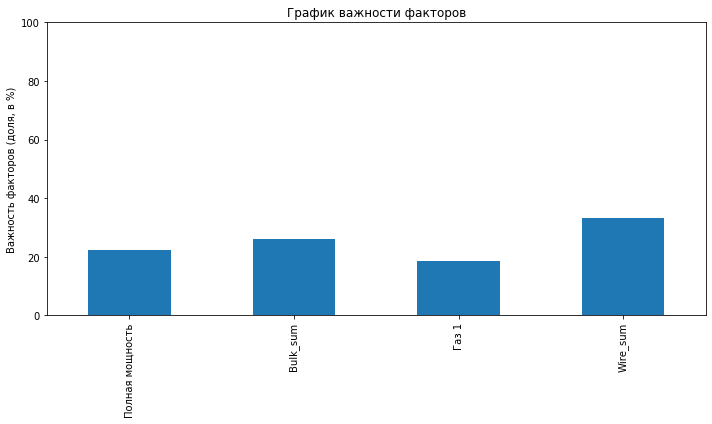

In [57]:
# importances = model_cat.feature_importances_

cat_importances = model_cat.get_feature_importance(data=None,
                       prettified=False,
                       thread_count=-1,
                       verbose=False)

# feature_names = [f'feature {i}' for i in range(features_train_01.shape[1])]
# feature_names = ['Полная мощность','Bulk_sum', 'Газ 1', 'Wire_sum']
features_train_01 = train.drop(['last'], axis = 1)
feature_names = [i for i in features_train_01.columns]
importances = pd.Series(cat_importances, index=feature_names)


fig, ax = plt.subplots(figsize = (10,6))
ax.set_ylim([0, 100])
importances.plot.bar(ax=ax)
ax.set_title("График важности факторов")
ax.set_ylabel("Важность факторов (доля, в %)")
fig.tight_layout()

Или же можно более наглядно представить на круговой диаграмме

(-1.116099870413455,
 1.1007666604958788,
 -1.1012071899996732,
 1.1089494143875838)

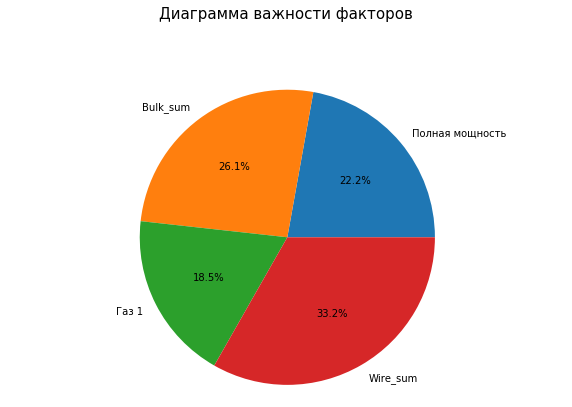

In [58]:
fig, ax = plt.subplots(figsize = (10,6))
# plt.suptitle("График важности факторов")
plt.title(label="Диаграмма важности факторов", fontsize=15, pad=55)
# ax.set_title("График важности факторов")
ax.pie(cat_importances, 
       labels=feature_names, 
       autopct='%1.1f%%', 
       shadow=False, 
       wedgeprops={'lw':0,'edgecolor':"k"}),#, 'ls':'--'}, 
#        rotatelabels=True)
#        wedgeprops=dict(width=0.5))
ax.axis("equal")

Итог: слабозначимых факторов выявлено не было. Все из них являются важными в процессе моделирования.<br>